В данной работе будет проводиться генерация обуви из очертаний. 

1. Данная работа основана на статье https://doi.org/10.48550/arXiv.1611.07004 Из нее я взял архитектуру системы.

2. Датасет с обувью и очертаниями взят из http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/





In [1]:
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.datasets import DatasetFolder
import torchvision.transforms as tt

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
import seaborn as sns
from IPython import display as dp
from tqdm.notebook import tqdm
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Загрузка данных

**Для начала загрузим данные**

 **следующую ячейку я позаимствовал из https://www.tensorflow.org/tutorials/generative/pix2pix?hl=en**

In [3]:
dataset_name = "edges2shoes"
# dataset_name = "facades"

_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

2165293056/2165283376 [==============================] - 1911s 1us/step


**дальнейшая реализация моя (я буду писать комменты к функциям не по канонам, сразу обьясняя свою мотивацию введения того или иного куска кода)** 

In [ ]:
def visualize_image(img):
  """
  Простая функция для визуализации одной картинки.
  
  Parameters
  ----------
  img: torch.Tenzor[3, imgsize, imgsize]

  """
  img = np.rollaxis(img.cpu().detach().numpy(), 0, 3)
  
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()

In [4]:
def split_2_edges_and_img(batch):
  """
  Т.к. в датасете картинки имеют вид сдвоенных картинок (одна - очертания обуви,
  вторая - сама фотография обуви), то тут я разделяю эту фотку на две

  Parameters
  ----------
  batch: очередной батч из DataLoader

  Returns:
  ----------
  turple(edges, imgs), где edges - батч очертаний,
                           imgs - соответствующий батч фотографий

  """
  edges, imgs = batch[:, :, :, :256], batch[:, :, :, 256:]

  return edges, imgs

In [5]:
class data_loader():
  """
  Dataloader, который применяет к выходу torch.DataLoader функцию
  'split_2_edges_and_img' и возвращает её вывод.

  """
  def __init__(self, batch_size):
    data = ImageFolder(root='/root/.keras/datasets/edges2shoes/',
                       transform=tt.ToTensor())
    self.loader = DataLoader(data, batch_size, shuffle=True, num_workers=2)

  def __len__(self):
    return(len(self.loader))

  def __iter__(self):
    iter_ = iter(self.loader)
    while True:
      try:
        data = next(iter_)[0]
        edges, imgs = split_2_edges_and_img(data)
        yield edges, imgs
      except StopIteration:
        break

**Посмотрим, как оно работает**

  0%|          | 0/50025 [00:00<?, ?it/s]

edges shape =  torch.Size([1, 3, 256, 256])
imgs shape =  torch.Size([1, 3, 256, 256])


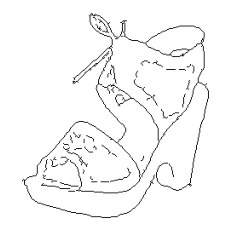

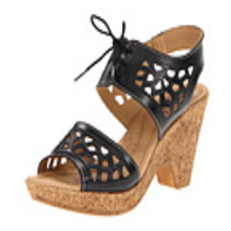

In [ ]:
loader = data_loader(1)
for edges, imgs in tqdm(loader):
  print('edges shape = ', edges.shape)
  print('imgs shape = ', imgs.shape)
  visualize_image(edges[0])
  visualize_image(imgs[0])
  break
del loader

# Реализация сети

## Generator

**Для начала реализуем generator. Он представляет из себя сеть U-Net**

In [6]:
class Generator(nn.Module):
  def __init__(self):
    nn.Module.__init__(self)
    # Encoder
    self.conv_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
    )
    self.conv_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
    )
    self.conv_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
    )
    self.conv_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
    )
    self.conv_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
    )
    self.conv_6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
    )
    self.conv_7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
    )
    self.conv_8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
    )

    # Decoder
    self.up_conv_8 = nn.Sequential(
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout2d(),
            nn.ReLU()
    )
    self.up_conv_7 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout2d(),
            nn.ReLU()
    )
    self.up_conv_6 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.Dropout2d(),
            nn.ReLU()
    )
    self.up_conv_5 = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU()
    )
    self.up_conv_4 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
    )
    self.up_conv_3 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
    )
    self.up_conv_2 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
    )
    self.up_conv_1 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
    )

  def forward(self, x):
    x1 = self.conv_1(x)
    x2 = self.conv_2(x1)
    x3 = self.conv_3(x2)
    x4 = self.conv_4(x3)
    x5 = self.conv_5(x4)
    x6 = self.conv_6(x5)
    x7 = self.conv_7(x6)
    x = self.conv_8(x7)
    
    x = self.up_conv_8(x)
    x = self.up_conv_7(torch.cat((x7, x), dim=1))
    x = self.up_conv_6(torch.cat((x6, x), dim=1))
    x = self.up_conv_5(torch.cat((x5, x), dim=1))
    x = self.up_conv_4(torch.cat((x4, x), dim=1))
    x = self.up_conv_3(torch.cat((x3, x), dim=1))
    x = self.up_conv_2(torch.cat((x2, x), dim=1))
    x = self.up_conv_1(torch.cat((x1, x), dim=1))

    return x

In [7]:
model = Generator()
data = next(iter(data_loader(1)))[0]
print(model(data).shape)
del model

torch.Size([1, 3, 256, 256])


In [8]:
def gen_loss(real_img, fake_img, dis_out, _lambda=100):
  """
  Подсчитывает лосс для генератора. 
  Он состоит из L1 лосса между реальным и сгенерированным изображениями 
  и кросс-энеропией для выхода дискриминатора на сгенерированном изобр.

  Parameters:
  ----------
  1) real_img: исходное изображение
  2) fake_img: сгенерированное изображение
  3) dis_out: выход дискриминатора на сгенерированном изображении
  4) _lambda: параметр в составном лоссе BCE_loss + _lambda * L1_loss

  """
  l1_loss = nn.L1Loss()(real_img, fake_img)
  bce_loss = nn.BCELoss()(dis_out, torch.ones_like(dis_out))

  return bce_loss + _lambda * l1_loss

## Discriminator

In [9]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv_1 = nn.Sequential(
              nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1, bias=False),
              nn.LeakyReLU(0.2)
    )
    self.conv_2 = nn.Sequential(
              nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(128),
              nn.LeakyReLU(0.2)
    )
    self.conv_3 = nn.Sequential(
              nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
              nn.BatchNorm2d(256),
              nn.LeakyReLU(0.2)
    )
    self.conv_4 = nn.Sequential(
              nn.Conv2d(256, 512, 4, stride=1, padding=1, bias=False),
              nn.BatchNorm2d(512),
              nn.LeakyReLU(0.2),
              nn.Conv2d(512, 1, 4, stride=1, padding=1, bias=False),
              nn.Sigmoid()
    )

  def forward(self, input, target):
    x = torch.cat((input, target), dim=1)
    x = self.conv_1(x)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = self.conv_4(x)
    
    return x


In [10]:
model = Discriminator()
data = next(iter(data_loader(1)))
print(model(*data).shape)
del model

torch.Size([1, 1, 30, 30])


In [11]:
def dis_loss(fake_out, real_out):
  """
  Подсчитывает лосс для дискриминатора.

  Parameters:
  ----------
  1) fake_out: выход дискриминатора для сгенерированного изображения
  2) real_out: выход дискриминатора для реального изображения

  """
  fake_loss = nn.BCELoss()(fake_out, torch.zeros_like(fake_out))
  real_loss = nn.BCELoss()(real_out, torch.ones_like(real_out))

  return fake_loss + real_loss

## Функция тренировки

In [12]:
def fit(model, optimizer, epochs, data_loader):
    model["discriminator"].train()
    model["generator"].train()
    if not hasattr(model['discriminator'], 'losses'):
      model['discriminator'].losses = []
      model['generator'].losses = []
      model['discriminator'].real_scores = []
      model['discriminator'].fake_scores = []
    torch.cuda.empty_cache()
        
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for edges, real_imgs in tqdm(data_loader):
            edges = edges.to(device)
            real_imgs = real_imgs.to(device)

            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](edges, real_imgs)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            fake_imgs = model["generator"](edges)

            # Pass fake images through discriminator
            fake_preds = model["discriminator"](edges, fake_imgs)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = dis_loss(fake_preds, real_preds)
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            fake_imgs = model["generator"](edges)
            
            # Try to fool the discriminator
            preds = model["discriminator"](edges, fake_imgs)
            loss_g = gen_loss(real_imgs, fake_imgs, preds)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        model['discriminator'].losses.append(np.mean(loss_d_per_epoch))
        model['generator'].losses.append(np.mean(loss_g_per_epoch))
        model['discriminator'].real_scores.append(np.mean(real_score_per_epoch))
        model['discriminator'].fake_scores.append(np.mean(fake_score_per_epoch))

        # save progress
        torch.save(model['discriminator'], '/content/gdrive/MyDrive/DLS/project/dis')
        torch.save(model['generator'], '/content/gdrive/MyDrive/DLS/project/gen')

        # losses visualization
        dp.clear_output(wait=True)
        sns.set_style('darkgrid')
        plt.figure(figsize=(15, 8))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, 1+len(model['discriminator'].losses)), model['discriminator'].losses)
        plt.plot(range(1, 1+len(model['generator'].losses)), model['generator'].losses)
        plt.legend(('discriminator', 'generator'))
        ax = plt.gca()
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')

        plt.subplot(1, 2, 2)
        plt.plot(range(1, 1+len(model['discriminator'].real_scores)), model['discriminator'].real_scores)
        plt.plot(range(1, 1+len(model['discriminator'].fake_scores)), model['discriminator'].fake_scores)
        plt.legend(('real_scores', 'fake_scores'))
        ax = plt.gca()
        ax.set_xlabel('epoch')
        ax.set_ylabel('probability')

        plt.show()

# Создание модели и обучение

**Можно содать модель с нуля, определив веса сверток ~ N(0, 0.02)**

In [ ]:
def set_weights(some):
  classname = some.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(some.weight.data, mean=0, std=0.02)

In [ ]:
lr = 2e-4
model = {
    'discriminator': Discriminator().to(device),
    'generator': Generator().to(device)
}
model['discriminator'].apply(set_weights)
model['generator'].apply(set_weights)

optim = {
    'discriminator': torch.optim.Adam(model['discriminator'].parameters(), lr),
    'generator': torch.optim.Adam(model['generator'].parameters(), lr)
}

data_l = data_loader(batch_size=64)

 **Либо загрузить предобученную модель**

In [13]:
lr = 2e-4
model = dict()
model['discriminator'] = torch.load('/content/gdrive/MyDrive/DLS/project/dis',
                          map_location=torch.device(device))
model['generator'] = torch.load('/content/gdrive/MyDrive/DLS/project/gen',
                          map_location=torch.device(device))

optim = {
    'discriminator': torch.optim.Adam(model['discriminator'].parameters(), lr),
    'generator': torch.optim.Adam(model['generator'].parameters(), lr)
}

data_l = data_loader(batch_size=64)

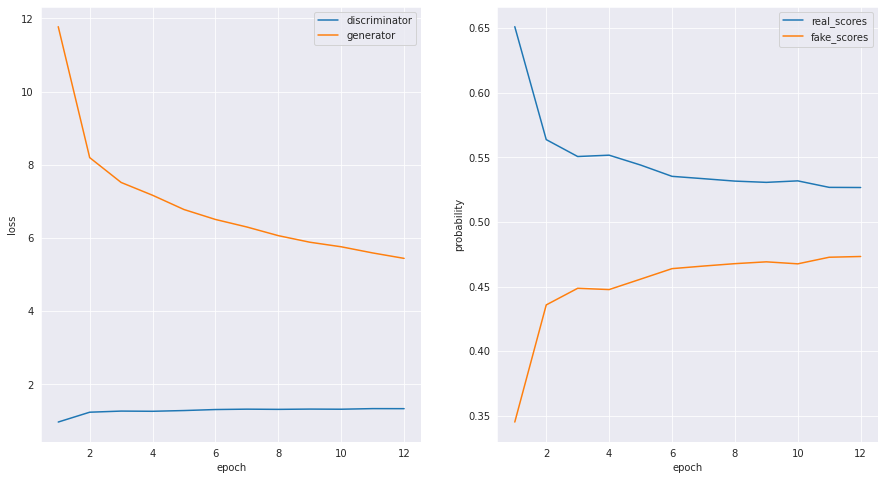

  0%|          | 0/782 [00:00<?, ?it/s]

In [ ]:
fit(model, optim, 15, data_l)